# Forecasting Consensus Expectations: Continuing Claims

## Data Exploration

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
plt.style.use("seaborn-v0_8-whitegrid")  # clean default style

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.api as sm
import plotly.express as px

from tqdm.auto import tqdm
from scipy import stats, special
from scipy.optimize import brentq
from collections import defaultdict
from itertools import product
from scipy.stats import t as student_t, norm, binomtest, jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan

In [2]:
OUT_DIR = "../out"        
DF_FILE       = "contClaims_df.parquet"
DF_FULL_FILE  = "contClaims_df_full.parquet"

df       = pd.read_parquet(os.path.join(OUT_DIR, DF_FILE),      engine="pyarrow")
df_full  = pd.read_parquet(os.path.join(OUT_DIR, DF_FULL_FILE), engine="pyarrow")

print("df shape     :", df.shape)
print("df_full shape:", df_full.shape)

df shape     : (8755, 10)
df_full shape: (9990, 10)


In [5]:
df.head()

,release_date,period,actual,median_forecast,economist,firm,forecast,asof,surprise,error
0,2002-08-08,2002-07-27,3532.0,3480.0,Bill Sharp,JPMorgan Chase & Co,3475.0,2002-08-06,52.0,-57.0
1,2002-08-08,2002-07-27,3532.0,3480.0,Ethan S Harris,BofA Securities Inc,3480.0,2002-08-02,52.0,-52.0
2,2002-08-08,2002-07-27,3532.0,3480.0,Maxwell Clarke,Idea Global,3519.0,2002-08-08,52.0,-13.0
3,2002-08-15,2002-08-03,3576.0,NaN,Ethan S Harris,BofA Securities Inc,3500.0,2002-08-09,NaN,-76.0
4,2002-08-15,2002-08-03,3576.0,NaN,Maxwell Clarke,Idea Global,3540.0,2002-08-12,NaN,-36.0


## 1 Rolling RMSE of crowd-median forecast

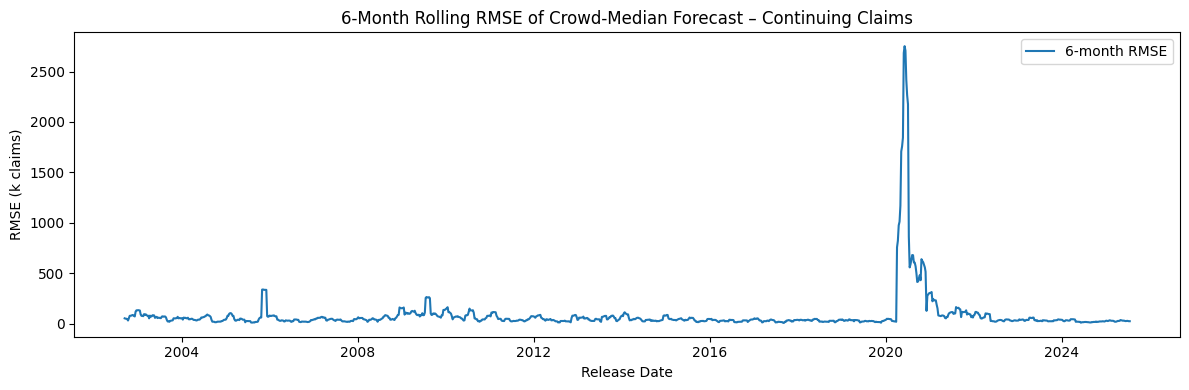

In [7]:
WINDOW = 6  # rolling window length (months)

# Build one‑row‑per‑release table: crowd median vs actual
med_vs_act = (
    df_full.groupby("release_date")
           .agg(crowd_median=("forecast", "median"),
                actual      =("actual",   "first"))
           .dropna()
           .sort_index()
)

# Compute forecast error and rolling RMSE
med_vs_act["err"] = med_vs_act["crowd_median"] - med_vs_act["actual"]
med_vs_act[f"rmse_{WINDOW}m"] = (
    med_vs_act["err"]
      .rolling(WINDOW, min_periods=WINDOW)
      .apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)
)

plt.figure(figsize=(12, 4))
plt.plot(med_vs_act.index, med_vs_act[f"rmse_{WINDOW}m"], label=f"{WINDOW}‑month RMSE")
plt.title(f"{WINDOW}-Month Rolling RMSE of Crowd‑Median Forecast – Continuing Claims")
plt.xlabel("Release Date"); plt.ylabel("RMSE (k claims)")
plt.legend(); plt.tight_layout(); plt.show()


## 2 Active economists per release date for different contiguity filters

Computing contiguity counts:   0%|          | 0/3 [00:00<?, ?it/s]

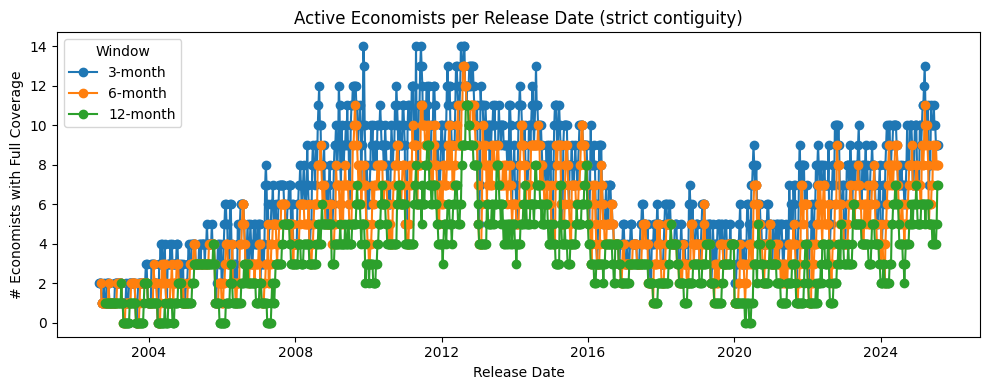

In [14]:
contiguity_windows = [3, 6, 12]
dates = sorted(df_full["release_date"].unique())
active_counts = {}

for w in tqdm(contiguity_windows, desc="Computing contiguity counts"):
    counts = []

    # start at w‑1 so the window includes the current release
    for idx in range(w - 1, len(dates)):
        t_date = dates[idx]
        window_dates = dates[idx - w + 1 : idx + 1]   # inclusive window

        # build matrix: one row per release, one column per economist
        panel = (
            df_full[df_full["release_date"].isin(window_dates)]
            .pivot_table(index="release_date",
                         columns="economist",
                         values="forecast",
                         aggfunc="first")        # take first forecast per release
        )

        # economist qualifies only if **every** release has a forecast (no NaNs)
        valid = panel.notna().all()
        counts.append((t_date, valid.sum()))

    active_counts[w] = pd.Series(
        [c for (_, c) in counts],
        index=[d for (d, _) in counts],
        name=f"{w}‑month"
    )

# ── plot ────────────────────────────────────────────────────────
plt.figure(figsize=(10, 4))
for w in contiguity_windows:
    s = active_counts[w]
    plt.plot(s.index, s.values,
             marker="o", label=f"{w}-month")
plt.title("Active Economists per Release Date (strict contiguity)")
plt.xlabel("Release Date")
plt.ylabel("# Economists with Full Coverage")
plt.legend(title="Window")
plt.tight_layout()
plt.show()


## 3 Distribution diagnostics for median forecast errors

C:\Users\nwong\AppData\Local\Temp\ipykernel_8140\1686772765.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d["median_forecast"].iloc[0] - d["actual"].iloc[0])


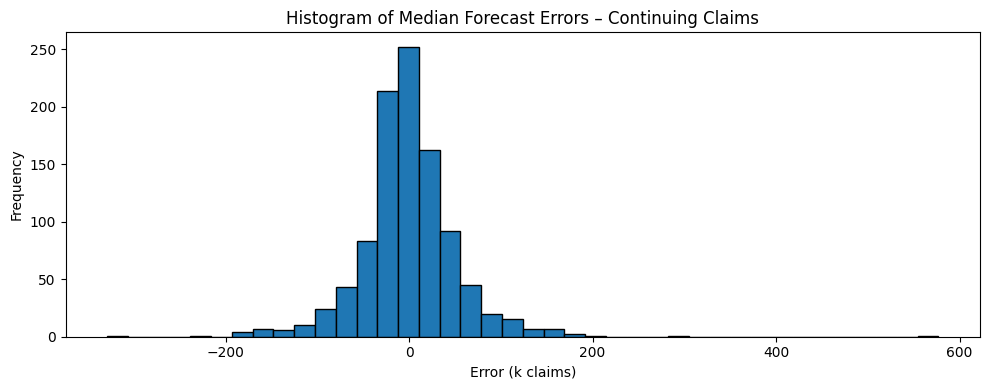

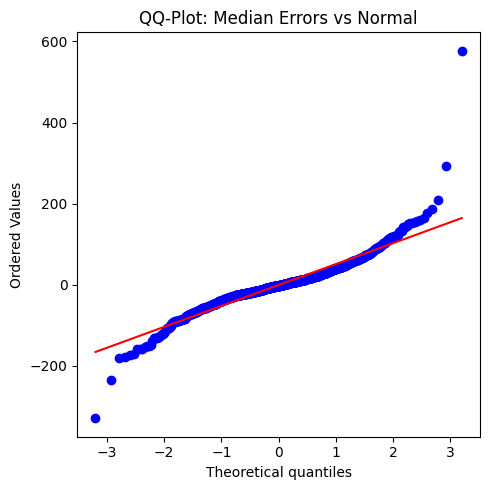

Jarque–Bera  : JB = 9,996.36, p = 0.0000
K‑S vs t‑fit : D  = 0.027,  p = 0.4525
C‑v‑M vs t‑fit: W² = 0.075, p = 0.7242


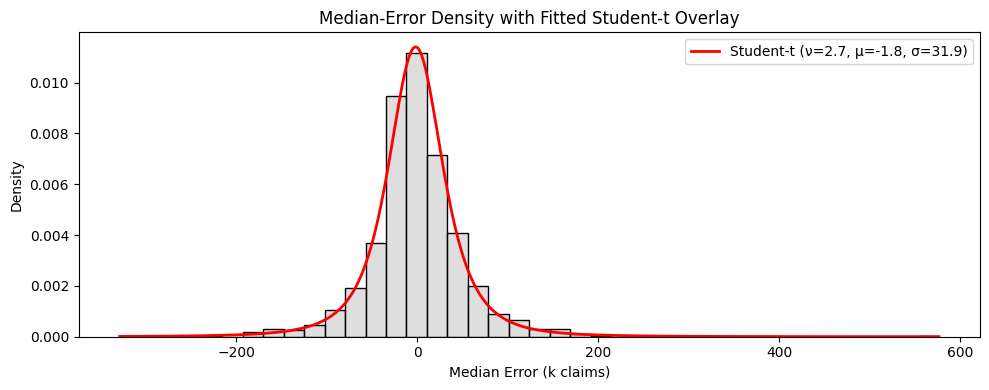


Student‑t implied parameters:
  ν  (df) : 2.72
  μ  (loc): -1.80  k
  σ  (scale): 31.94  k


In [ ]:
# Build vector of median errors (one per release) for COVID-filtered data
median_err = (
    df.groupby("release_date")
           .apply(lambda d: d["median_forecast"].iloc[0] - d["actual"].iloc[0])
           .dropna()
           .values
)

# Histogram
plt.figure(figsize=(10, 4))
plt.hist(median_err, bins=40, edgecolor="k")
plt.title("Histogram of Median Forecast Errors – Continuing Claims")
plt.xlabel("Error (k claims)"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()

# QQ‑plot vs Normal
plt.figure(figsize=(5, 5))
st.probplot(median_err, dist="norm", plot=plt)
plt.title("QQ‑Plot: Median Errors vs Normal"); plt.tight_layout(); plt.show()

# Normality & Student‑t tests
jb_stat, jb_p = st.jarque_bera(median_err)
nu_hat, loc_hat, scale_hat = st.t.fit(median_err)
ks_stat, ks_p = st.kstest(median_err, "t", args=(nu_hat, loc_hat, scale_hat))
cvm_res = st.cramervonmises(median_err,
                            lambda x: st.t.cdf(x, df=nu_hat, loc=loc_hat, scale=scale_hat))

print(f"Jarque–Bera  : JB = {jb_stat:,.2f}, p = {jb_p:.4f}")
print(f"K‑S vs t‑fit : D  = {ks_stat:.3f},  p = {ks_p:.4f}")
print(f"C‑v‑M vs t‑fit: W² = {cvm_res.statistic:.3f}, p = {cvm_res.pvalue:.4f}")

# Overlay fitted Student‑t PDF
xgrid = np.linspace(median_err.min(), median_err.max(), 400)
pdf_t = st.t.pdf(xgrid, df=nu_hat, loc=loc_hat, scale=scale_hat)

plt.figure(figsize=(10, 4))
sns.histplot(median_err, bins=40, stat="density", edgecolor="k", color="lightgray")
plt.plot(xgrid, pdf_t, "r-", lw=2,
         label=f"Student‑t (ν={nu_hat:.1f}, μ={loc_hat:.1f}, σ={scale_hat:.1f})")
plt.title("Median‑Error Density with Fitted Student‑t Overlay")
plt.xlabel("Median Error (k claims)"); plt.ylabel("Density")
plt.legend(); plt.tight_layout(); plt.show()

print("\nStudent‑t implied parameters:")
print(f"  ν  (df) : {nu_hat:.2f}")
print(f"  μ  (loc): {loc_hat:.2f}  k")
print(f"  σ  (scale): {scale_hat:.2f}  k")


## 4 Cross-sectional spread vs |median error|

COVID‑filtered : Pearson r =  0.147 (p = 0.0000) | Spearman ρ =  0.231 (p = 0.0000)
Full           : Pearson r =  0.673 (p = 0.0000) | Spearman ρ =  0.330 (p = 0.0000)


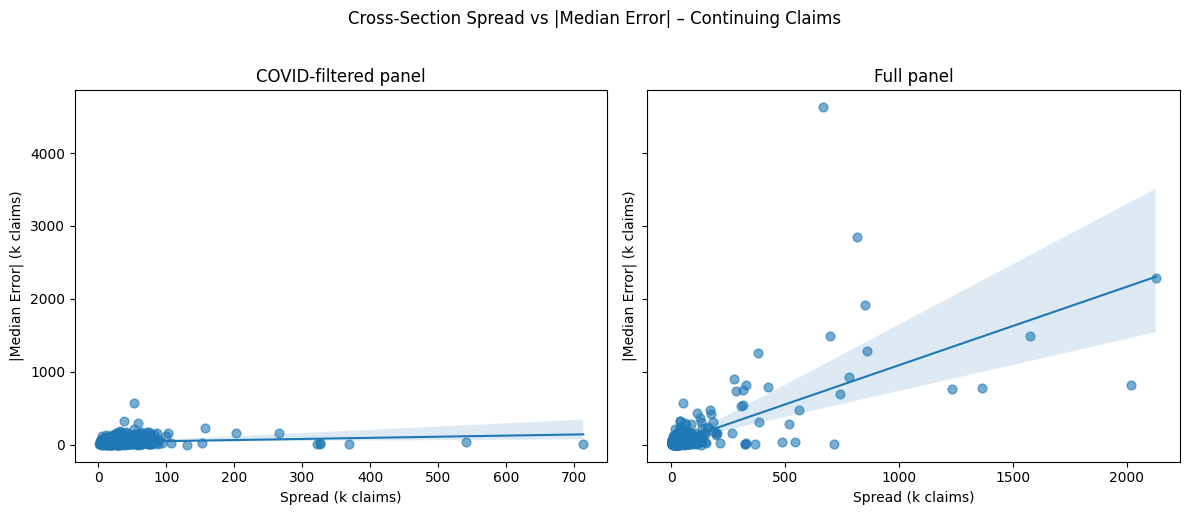

In [ ]:
panels = {"COVID‑filtered": df, "Full": df_full}

fig, axs = plt.subplots(1, len(panels), figsize=(6 * len(panels), 5), sharey=True)

for ax, (label, panel) in zip(axs, panels.items()):
    # Build per‑release table
    tbl = (
        panel.groupby("release_date")
              .agg(spread=("forecast", "std"),
                   median_fc=("median_forecast", "median"),
                   actual=("actual", "first"))
              .dropna(subset=["spread", "actual"])
              .assign(abs_err=lambda d: (d["median_fc"] - d["actual"]).abs())
    )

    # Keep only informative rows (positive spread & error)
    tbl = tbl.query("spread > 0 & abs_err > 0")

    # Scatter + regression line
    sns.regplot(data=tbl, x="spread", y="abs_err",
                scatter_kws={"alpha": 0.6, "s": 40},
                line_kws={"lw": 1.5}, ax=ax)
    ax.set_title(f"{label} panel")
    ax.set_xlabel("Spread (k claims)")
    ax.set_ylabel("|Median Error| (k claims)")

    # Correlations (skip if series is constant / too short)
    if tbl["spread"].nunique() > 1 and tbl["abs_err"].nunique() > 1:
        pearson  = st.pearsonr(tbl["spread"], tbl["abs_err"])
        spearman = st.spearmanr(tbl["spread"], tbl["abs_err"])
        print(f"{label:<15}: Pearson r = {pearson.statistic:6.3f} (p = {pearson.pvalue:.4f}) | "
              f"Spearman ρ = {spearman.statistic:6.3f} (p = {spearman.pvalue:.4f})")
    else:
        print(f"{label:<15}: insufficient variation for correlation statistics")

plt.suptitle("Cross‑Section Spread vs |Median Error| – Continuing Claims", y=1.02)
plt.tight_layout(); plt.show()

## 5 Log-log regression: ln|error| vs ln(spread)

In [13]:
panels = {"COVID‑filtered": df, "Full": df_full}

for label, panel in panels.items():
    # Assemble table
    tbl = (
        panel.groupby("release_date")
              .agg(spread=("forecast", "std"),
                   median_fc=("median_forecast", "median"),
                   actual=("actual", "first"))
              .dropna(subset=["spread", "actual"])
              .assign(abs_err=lambda d: (d["median_fc"] - d["actual"]).abs())
              .query("spread > 0 & abs_err > 0")               # avoid log(0)
    )

    if len(tbl) < 10:        # guard: need enough data for regression
        print(f"\n{label} panel: not enough observations for regression – skipped.")
        continue

    tbl["ln_spread"]  = np.log(tbl["spread"])
    tbl["ln_abs_err"] = np.log(tbl["abs_err"])

    X = sm.add_constant(tbl["ln_spread"])
    model = sm.OLS(tbl["ln_abs_err"], X).fit(cov_type="HAC", cov_kwds={"maxlags": 12})

    print(f"\n====================  {label} panel  ====================")
    print(model.summary())


====================  COVID‑filtered panel  ====================
                            OLS Regression Results                            
Dep. Variable:             ln_abs_err   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     20.67
Date:                Wed, 23 Jul 2025   Prob (F-statistic):           6.13e-06
Time:                        13:58:51   Log-Likelihood:                -1471.6
No. Observations:                 982   AIC:                             2947.
Df Residuals:                     980   BIC:                             2957.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------